In [1]:
from __future__ import absolute_import, division, print_function
import glob
import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import pdb
import json
import getpass
from scipy import stats
from sklearn import linear_model
from numpy import linalg as LA
import numpy.random as npr
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.manifold import MDS
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_NET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_NET)
from tools_lnd import make_h_trial_rule, get_model_params, plot_epoch_dynamics_3D
from tools_lnd import gen_trials_from_model_dir, make_FP_axs, take_names, get_filename, make_D_use

In [2]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v4_figs','paper_figs','fig1','fig1_single_task_fp_mov')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [3]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['delaygo',]

rule_trains_str = '_'.join(rule_trains)

rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag' #train diag network
ruleset = 'all'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = '0'
lr = -7
net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'data/rnn/multitask/stepnet/final'
m = os.path.join(p,data_folder,ruleset,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

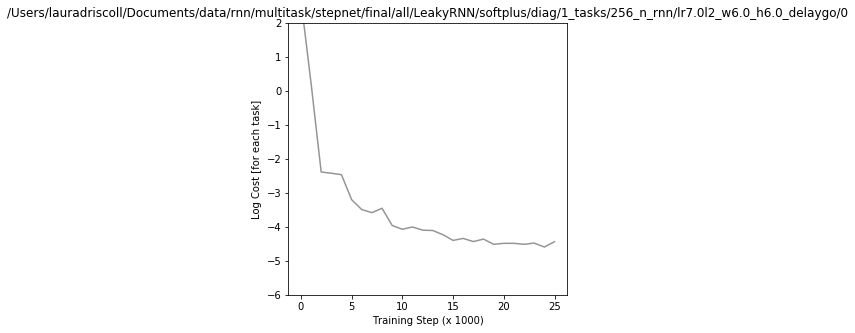

In [4]:
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for ri in range(len(rule_trains)):
    r = rule_trains[ri]
    c = cmap((ri+1)/(len(rule_trains)+1))
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+r])
    plt.plot(x,'-',c = c)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-6,2])
    
plt.title(m)
plt.show()    

In [5]:
#output dynamics
rule = rule_trains[0]
h,trial,tasks = make_h_trial_rule(m)
w_in, b_in, w_out, b_out = get_model_params(m)

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo/0/model.ckpt
Model restored from file: /Users/la

In [6]:
plt.rcParams.update({'font.size': 16})

lim = 1
lil_axes = False
plot_unstable = True
stim_theta = 0 #which fps to plot
rule = rule_trains[0]
fp_file = 'tf_fixed_pts_manytrials'

h,trial,tasks = make_h_trial_rule(m,mode = 'test')
# pca = PCA(n_components = 10)
# x = np.transpose(h[rule],(2,1,0))
# _ = pca.fit_transform(np.reshape(x,(x.shape[0],-1)).T)
# D_use = -pca.components_.T[:,1:]
D_use = make_D_use(m,rule,'stim1',0,'pca_h')
D_use[:,0] = D_use[:,0]
D_use[:,1] = -D_use[:,1]
D_use[:,2] = w_out[:,2]

for epoch in trial[rule].epochs.keys():
    ax = plot_epoch_dynamics_3D(m,fp_file,epoch,h,trial,rule,D_use,y_set = [stim_theta,],lim = lim,
                                plot_eigenspect = False,lil_axes = lil_axes,fig_scale = 4,plot_title = True,
                                plot_unstable = plot_unstable,ax_labels = ['PC1','PC2','Output '+'$\cos{\theta}$'],
                                q_thresh = -6,fp_size = 250)
    
    ax.set_xlim([-.9,.9])
    ax.set_ylim([-.9,.9])
    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(x1, x2, num=2), np.linspace(y1, y2, num=2))
    z = xx*0
    ax.plot_surface(xx, yy, z, alpha=0.1)
    
    
    ax.set_zlim([-1.1,1.1])
    ax.set_zticks([-1,1])
    ax.set_zticklabels([-1,1],fontsize = 20)
    
    ax.set_xticks([])
    ax.set_yticks([])
    plt.axis('on')
    ax.grid(True)
    
    if epoch == 'fix1':
        ax.set_zlabel('Output '+r'$\cos{\theta}$',labelpad=-10)
        ax.text(x1, y1, 0, 'Output Null', (1,0,0),fontsize = 14)
        
    ax.set_xlabel('Stimulus Period \n State PC1', labelpad=-5,fontsize = 14)
    ax.set_ylabel('Stimulus Period \n State PC2', labelpad=-5,fontsize = 14)
    
    ax.dist = 11
    
    
    if lil_axes ==True:
        figname = rule + '_' + epoch +'lil_axes.pdf'
    else:
        figname = rule + '_' + epoch +'.pdf'
        
    if not os.path.exists(figpath):
        os.makedirs(figpath)
    plt.savefig(os.path.join(figpath,figname))

    plt.subplots_adjust(bottom=0.3, right=.9, top=0.9,wspace = 0,hspace = 0)
    
    if lil_axes ==True:
        figname = rule + '_' + epoch +'lil_axes.png'
    else:
        figname = rule + '_' + epoch +'.png'
    plt.savefig(os.path.join(figpath,figname))

    plt.show()

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softpl

KeyboardInterrupt: 

In [9]:
def plot_epoch_dynamics_3D_mov(m,fp_file,epoch,h,trial,rule,D_use,
                        y_set = range(0,360,36),plot_eigenspect = True,lim=4,epoch_axes =[],h_epoch = [],
                        stim_loc_fp = 0,lil_axes = True,plot_unstable = True, ax_labels = [],nr = 1,
                        nc = 1,al = .5,markersize = 100,fp_size = 100,lw = 5,cmap = 'hsv',q_thresh = -10,
                        fig_scale = 6,plot_title=False, plot_fps = True):
    
    '''
    Plotting trajectories and FPs in 3D space
    m: model directory
    fp_file: where to find fps
    epoch: which epoch to plot
    h: use make_h_trial_rule, makes directoory of h for each rule
    D_use: dimensions to plot it
    y_set: which trials to plot fps for
    plot_eigenspect = whether to plot
    lim= xy 
    epoch_axes =[],
    stim_loc_fp = 0
    lil_axes = whether to make lil axes labels
    plot_unstable = plot unstable fps? true/false
    ax_labels = list of strings,
    nr/nc = num rows and columns of subplots
    al = transparency of lines
    markersize = 100,
    fp_size = 300,
    lw = linewidth,
    cmap = 'hsv',
    q_thresh = -10
    '''

    LAG = 3 
    cmap = plt.get_cmap(cmap)
    xs = np.linspace(-1, 1, 1000)
    ys = np.sqrt(1 - xs**2)
    
    epoch_name, rule_name, epoch_axes_name, h_epoch = take_names(epoch,rule,epoch_axes = epoch_axes,
                                                                 h_epoch = epoch)
    
    fldr = os.path.join(figpath,'epoch_dynamics_gif/') #set path for where all the movies go
    if not os.path.exists(fldr):
        os.makedirs(fldr)

    movie_dir = os.path.join(fldr,epoch_name) #set path for where all the frames go (concatenate at the end)
    if not os.path.exists(movie_dir):
        os.makedirs(movie_dir)
    
    T_inds = get_T_inds(trial[rule],h_epoch)
    if T_inds[0]>0:
            T_inds = range(T_inds[0]-1,T_inds[-1]) #start from the timestep before stim onset etc
    
    stim1_locs = np.min(trial[rule].stim_locs[:,[0,2]],axis=1) #only workds for single modality tasks
    y_locs = trial[rule].y_loc[-1,:]
    
    movie_inds = T_inds[0:-1:1] #frame every 6 timesteps
    if plot_fps:
        mov_i = len(movie_inds)
    else:
        mov_i = 0
    for im_num in movie_inds:
        fig = plt.figure(figsize=(fig_scale*nc,fig_scale*nr),tight_layout=True,facecolor='white')
        ax = fig.add_axes([0,0,1,1], projection='3d');
        
        ##plot trajectory
        plot_set_start = np.max([T_inds[0],im_num-LAG])
        plot_set = range(plot_set_start,im_num)
        
        for t in range(0,np.shape(h[rule])[1],int(np.shape(h[rule])[1]/10)):
            
            if epoch is 'fix1':
                c = cmap(stim_loc_fp/(2*np.pi))
                if plot_fps:
                    al_use = 1
                else:
                    al_use = al/3
            elif (stim1_locs[t]==stim_loc_fp):
                if plot_fps:
                    al_use = 1
                else:
                    al_use = al/3
                c = cmap(stim1_locs[t]/(2*np.pi))
            else:
                al_use = al/3
                c = cmap(stim1_locs[t]/(2*np.pi))
    
            h_D0 = np.dot(h[rule][T_inds,t,:],D_use)
            h_D = np.dot(h[rule][plot_set,t,:],D_use)

            ax.plot3D(h_D[:,0],h_D[:,1],h_D[:,2],
                      c = c,
                      alpha = al_use,linewidth = lw)

            ax.scatter(h_D0[0,0],h_D0[0,1],h_D0[0,2],
                       s = markersize*1.5,
                       marker = 'x',
                       c = c,
                       alpha = al_use,
                       linewidth = lw)


            if stim1_locs[t]==stim_loc_fp or epoch=='fix1':
        
                if plot_fps:

                    ax.plot3D(h_D[:,0],h_D[:,1],h_D[:,2],
                              c = 'w',
                              alpha = 1,
                              linewidth = lw/2)

                    ax.scatter(h_D0[0,0],h_D0[0,1],h_D0[0,2],
                               s = markersize,
                               marker = 'x',
                               c = 'w',
                               alpha = 1,
                               linewidth = lw/2)

        lim = lim
        ax.set_zlim([-1.2,1.2])
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        plt.axis('off')

#         if lil_axes ==True:
#             make_lil_axes(ax,ax_labels,fontsize = 20,fac_len = 2)

        if plot_title:
            plt.title('Single Task : '+r"$\bf{" + rule_name + "}$"+ '\n '+epoch_name+' dynamics',y = .9,fontsize = 16)

        if plot_fps:
            for ind_stim_loc_anti in y_set:
                fps_anti, J_xstar, q_star = make_fp_struct(m,trial[rule],fp_file,rule,epoch,ind_stim_loc_anti)

                #remove pts that aren't that slow
                fps_anti = fps_anti[np.log10(q_star)<q_thresh,:]
                J_xstar = J_xstar[np.log10(q_star)<q_thresh,:,:]

                eig_decomps = comp_eig_decomp(J_xstar)
                fps_tdr_anti = np.dot(fps_anti,D_use)
                fp_c = cmap(ind_stim_loc_anti/(360))

                for s in range(len(eig_decomps)):

                    X_trial = np.dot(fps_anti[s,:],D_use)

                    stability_metric = 1.4 - np.max(eig_decomps[s]['evals'].real)

                    ax.scatter(X_trial[0], X_trial[1],X_trial[2],s = fp_size,marker = 'o',
                                   edgecolors = 'w',facecolors = 'k',alpha = stability_metric) 
                    
        ax.set_xlim([-.9,.9])
        ax.set_ylim([-.9,.9])
        [x1,x2] = ax.get_xlim()
        [y1,y2] = ax.get_ylim()
        xx, yy = np.meshgrid(np.linspace(x1, x2, num=2), np.linspace(y1, y2, num=2))
        z = xx*0
        ax.plot_surface(xx, yy, z, alpha=0.1)


        ax.set_zlim([-1.1,1.1])
        ax.set_zticks([-1,1])
        ax.set_zticklabels([-1,1],fontsize = 20)

        ax.set_xticks([])
        ax.set_yticks([])
        plt.axis('on')
        ax.grid(True)

        if epoch == 'stim1':
            ax.set_zlabel('Output '+r'$\cos{\theta}$',labelpad=-10)
            ax.text(x1, y1, 0, 'Output Null', (1,0,0),fontsize = 14)

        ax.set_xlabel('Stimulus Period \n State PC1', labelpad=-5,fontsize = 14)
        ax.set_ylabel('Stimulus Period \n State PC2', labelpad=-5,fontsize = 14)

        ax.dist = 11
                
        mov_i += 1 
        plt.savefig(movie_dir +'/'+ str(mov_i) + '.png')
        
    images = []
    for t in range(1,mov_i):
        filename = movie_dir +'/'+ str(t) + '.png'
        images.append(imageio.imread(filename))

    imageio.mimsave(movie_dir+'/movie.gif', images)

    return ax

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softpl

KeyboardInterrupt: 

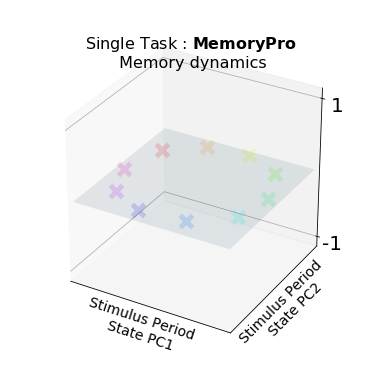

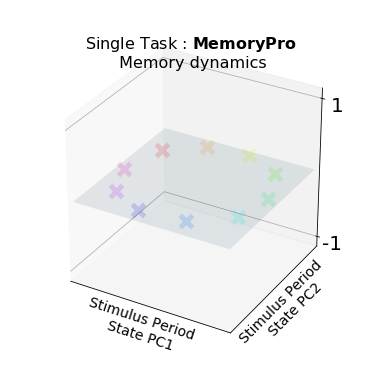

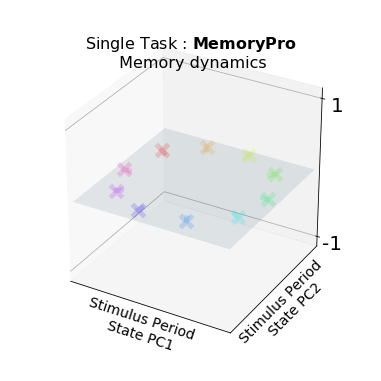

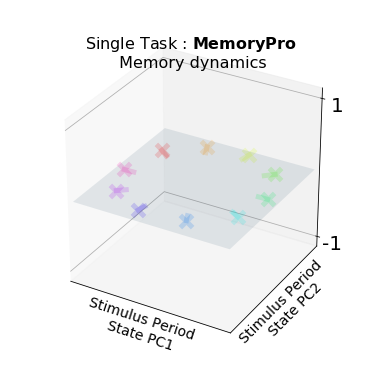

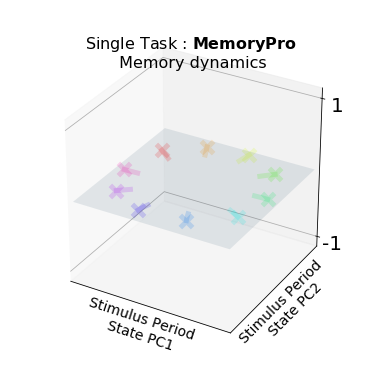

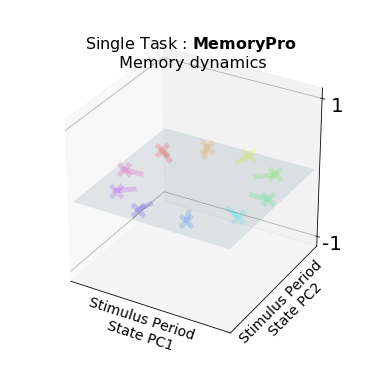

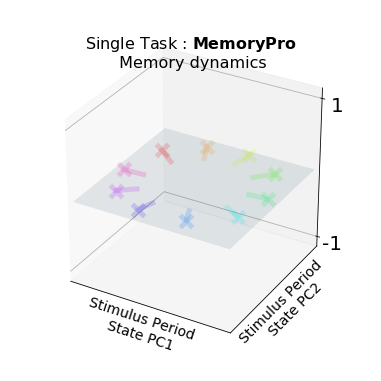

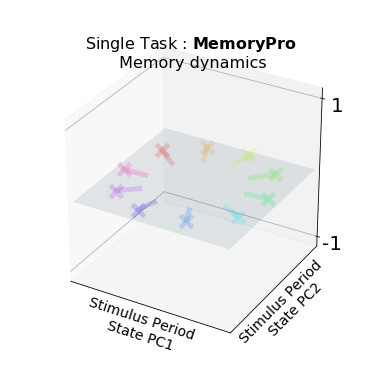

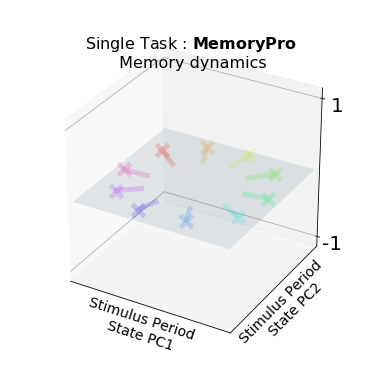

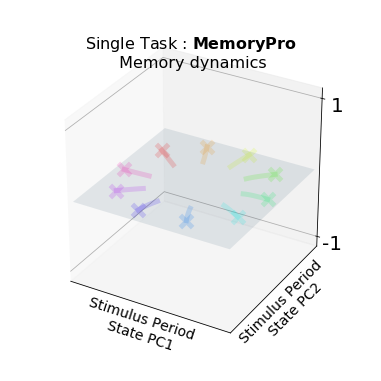

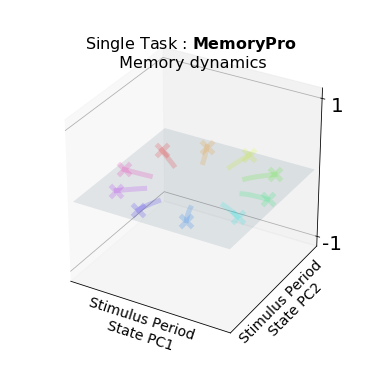

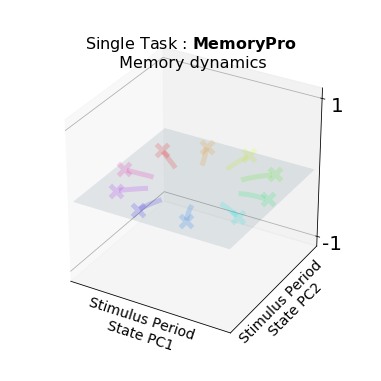

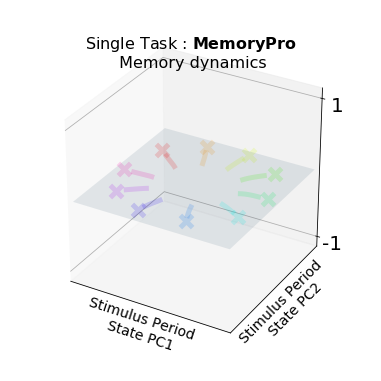

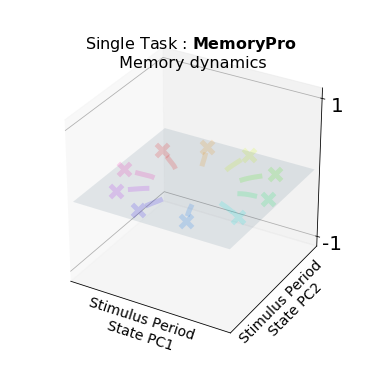

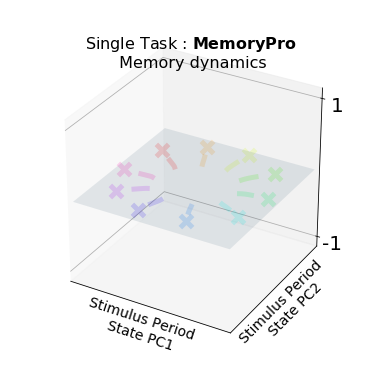

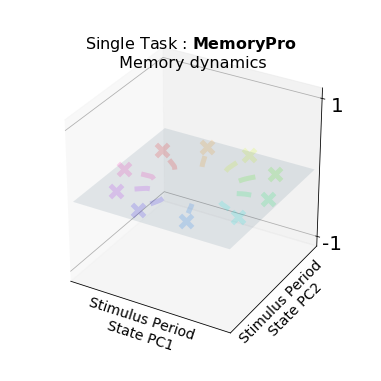

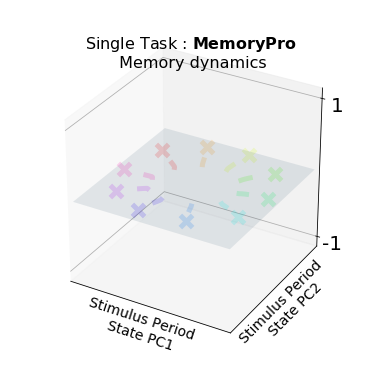

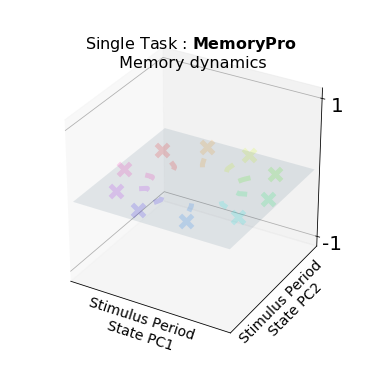

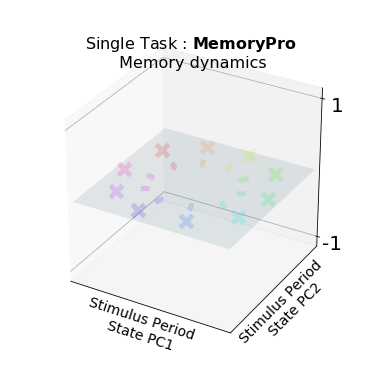

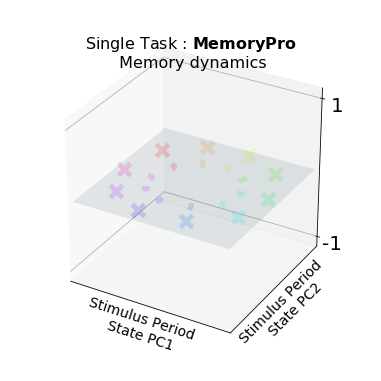

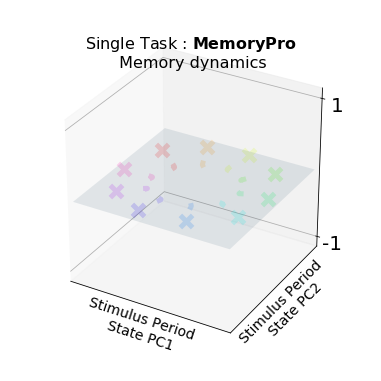

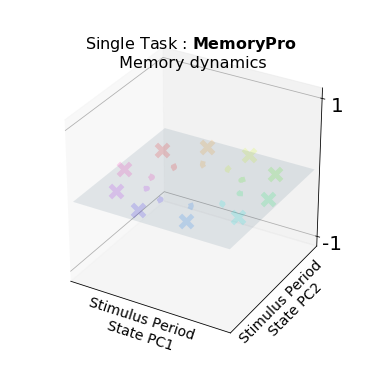

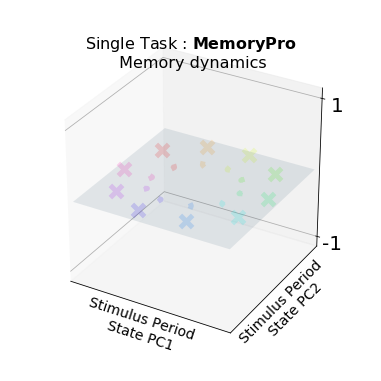

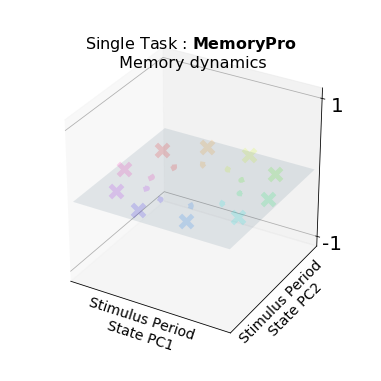

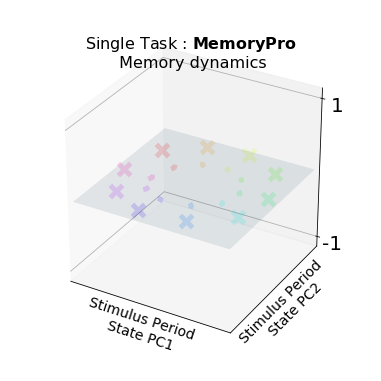

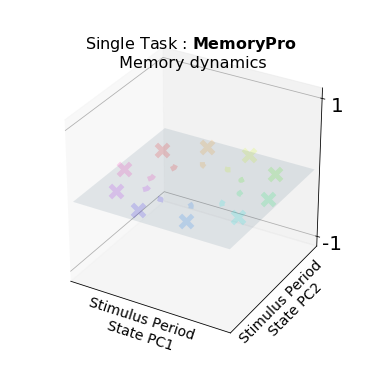

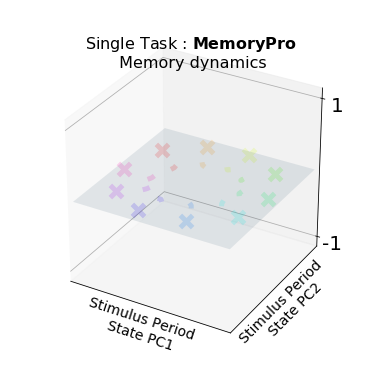

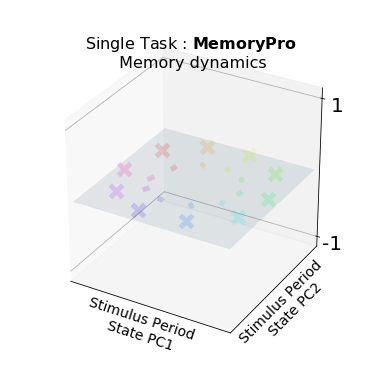

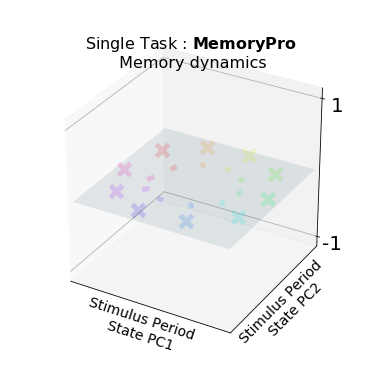

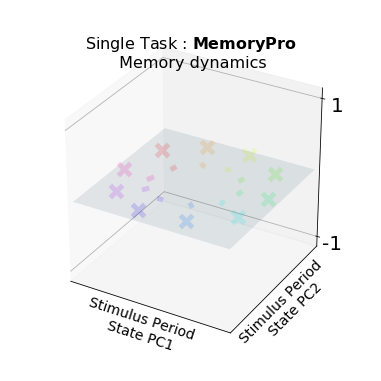

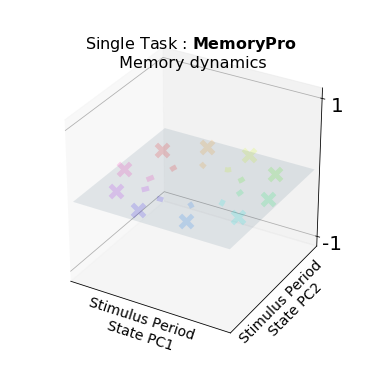

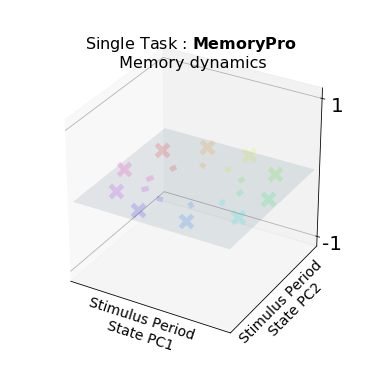

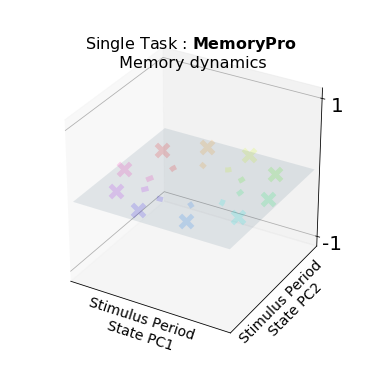

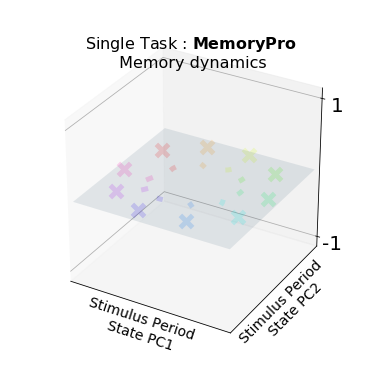

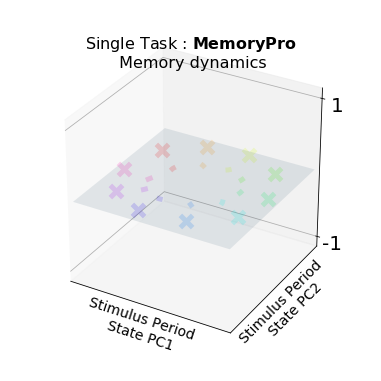

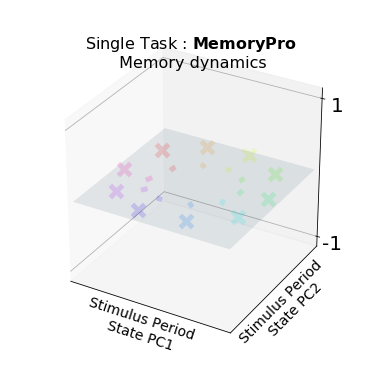

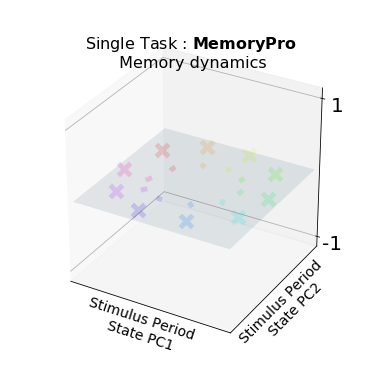

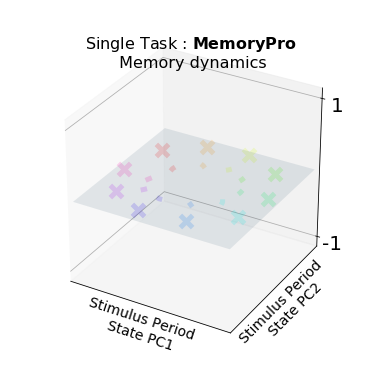

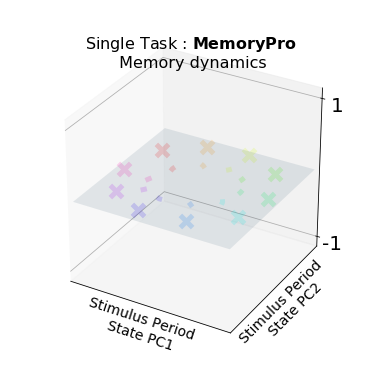

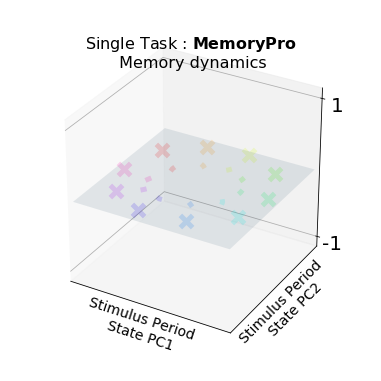

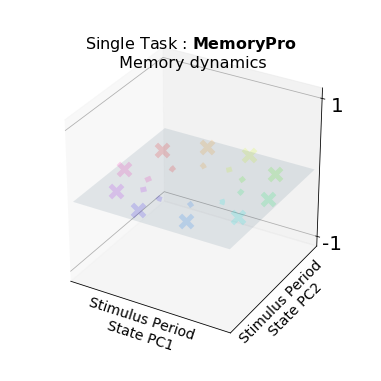

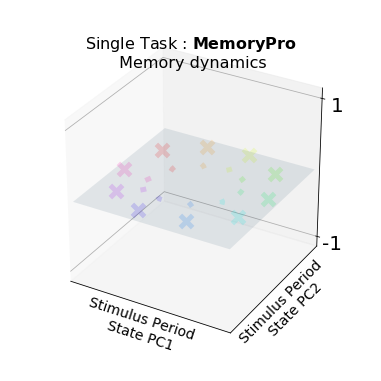

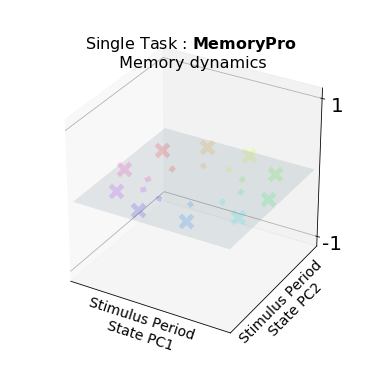

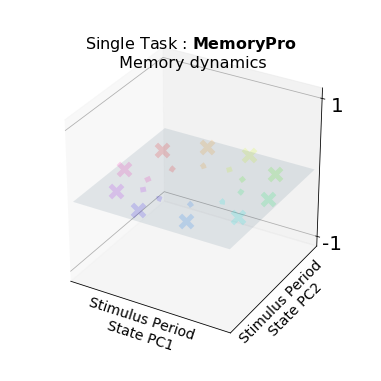

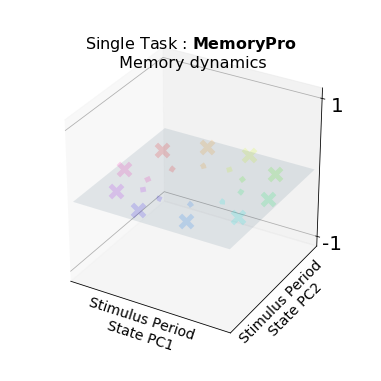

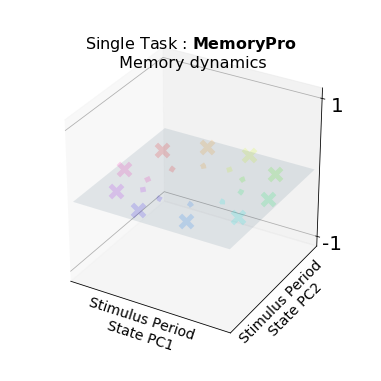

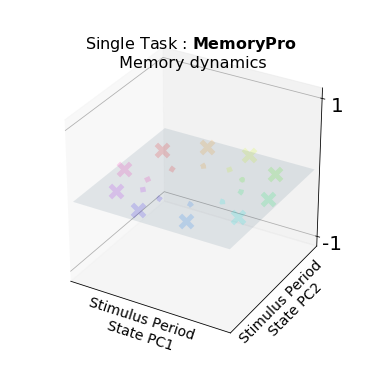

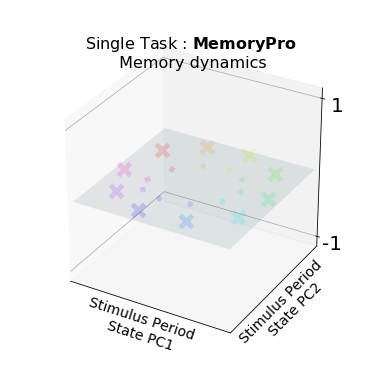

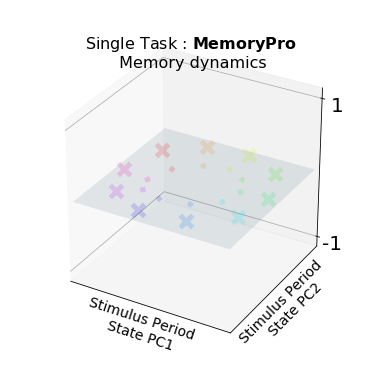

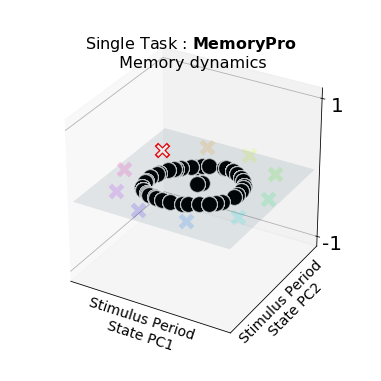

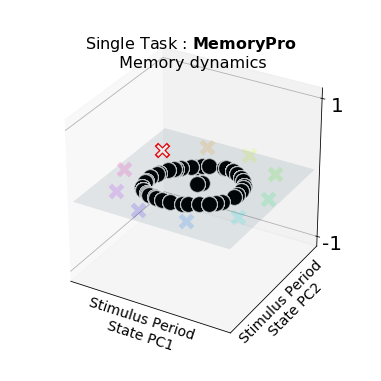

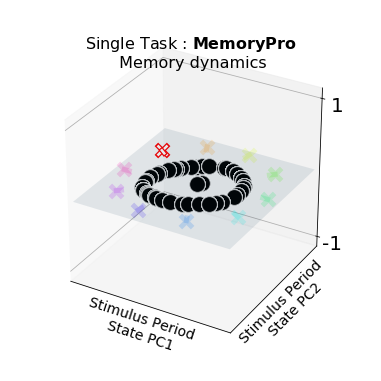

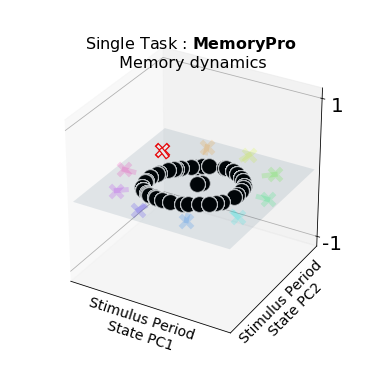

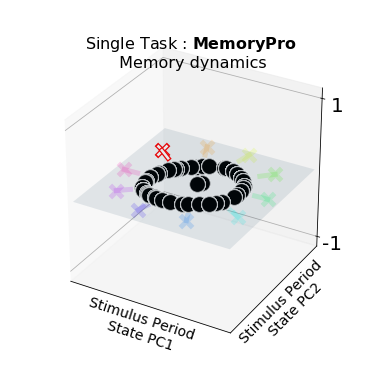

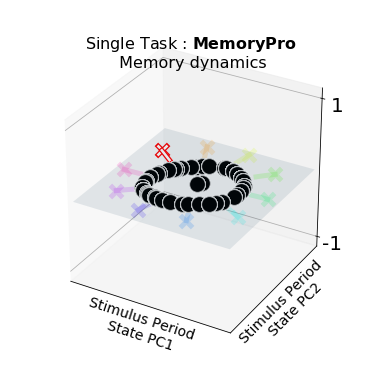

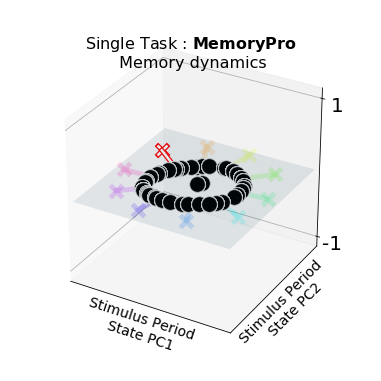

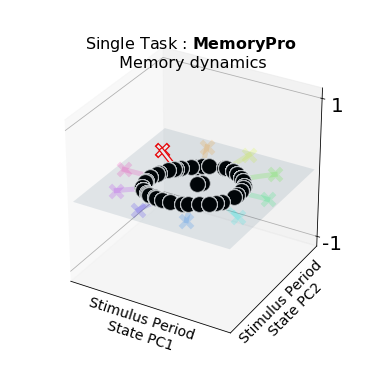

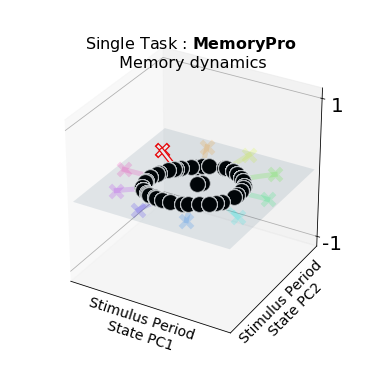

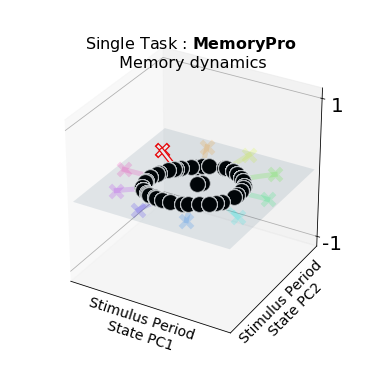

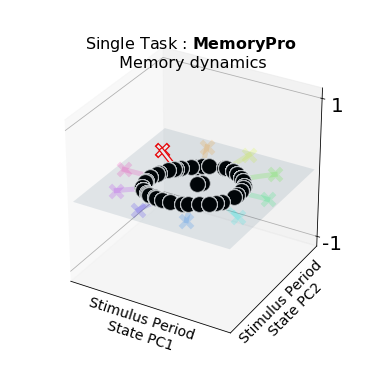

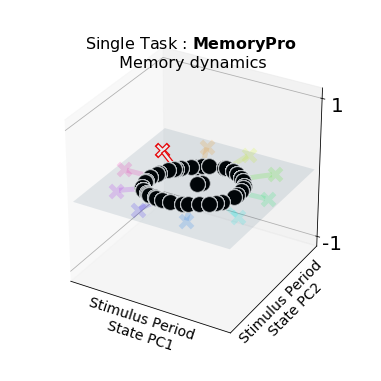

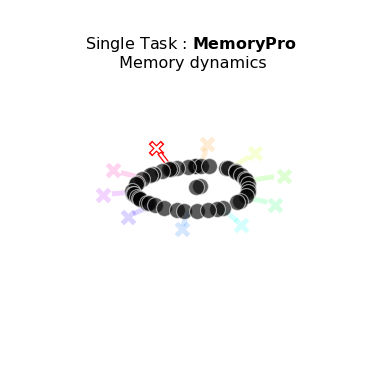

In [12]:
from tools_lnd import get_T_inds, make_fp_struct, comp_eig_decomp
import imageio

plt.rcParams.update({'font.size': 16})

lim = 1
lil_axes = False
plot_unstable = True
stim_theta = 0 #which fps to plot
rule = rule_trains[0]
fp_file = 'tf_fixed_pts_manytrials'

h,trial,tasks = make_h_trial_rule(m,mode = 'test')
# pca = PCA(n_components = 10)
# x = np.transpose(h[rule],(2,1,0))
# _ = pca.fit_transform(np.reshape(x,(x.shape[0],-1)).T)
# D_use = -pca.components_.T[:,1:]
D_use = make_D_use(m,rule,'stim1',0,'pca_h')
D_use[:,0] = D_use[:,0]
D_use[:,1] = -D_use[:,1]
D_use[:,2] = w_out[:,2]

for epoch in trial[rule].epochs.keys():#[stim_theta,]
    ax = plot_epoch_dynamics_3D_mov(m,fp_file,epoch,h,trial,rule,D_use,y_set = range(0,360,36),lim = lim,
                                plot_eigenspect = False,lil_axes = lil_axes,fig_scale = 5,plot_title = True,
                                plot_unstable = plot_unstable,ax_labels = ['PC1','PC2','Output '+'$\cos{\theta}$'],
                                q_thresh = -6,fp_size = 250, plot_fps = False)
    
    ax = plot_epoch_dynamics_3D_mov(m,fp_file,epoch,h,trial,rule,D_use,y_set = range(0,360,36),lim = lim,
                                plot_eigenspect = False,lil_axes = lil_axes,fig_scale = 5,plot_title = True,
                                plot_unstable = plot_unstable,ax_labels = ['PC1','PC2','Output '+'$\cos{\theta}$'],
                                q_thresh = -6,fp_size = 250, plot_fps = True)

In [19]:
from tools_lnd import FixedPoint_Model,generate_trials
import tools
model = FixedPoint_Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    # create a trial
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, batch_size=40)# get feed_dict
    feed_dict = tools.gen_feed_dict(model, trial, hparams)

Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/final/all/LeakyRNN/softplus/diag/1_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_delaygo/0/model.ckpt


In [29]:
print(trial.epochs.values()[1][0])

25


In [26]:
trial.epochs

{'delay1': (50, 100),
 'fix1': (None, 25),
 'go1': (100, None),
 'stim1': (25, 50)}